In [1]:
import pandas as pd
import numpy as np
from gensim.models import ldamodel
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
import pyLDAvis.gensim
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import matplotlib.pyplot as plt

In [2]:
news_df = pd.read_csv('us_equities_news_dataset.csv')
news_df.head()

,id,ticker,title,category,content,release_date,provider,url,article_id
0,221515,NIO,Why Shares of Chinese Electric Car Maker NIO A...,news,What s happening\nShares of Chinese electric c...,2020-01-15,The Motley Fool,https://invst.ly/pigqi,2060327
1,221516,NIO,NIO only consumer gainer Workhorse Group amon...,news,Gainers NIO NYSE NIO 7 \nLosers MGP Ingr...,2020-01-18,Seeking Alpha,https://invst.ly/pje9c,2062196
2,221517,NIO,NIO leads consumer gainers Beyond Meat and Ma...,news,Gainers NIO NYSE NIO 14 Village Farms In...,2020-01-15,Seeking Alpha,https://invst.ly/pifmv,2060249
3,221518,NIO,NIO NVAX among premarket gainers,news,Cemtrex NASDAQ CETX 85 after FY results \n...,2020-01-15,Seeking Alpha,https://invst.ly/picu8,2060039
4,221519,NIO,PLUG NIO among premarket gainers,news,aTyr Pharma NASDAQ LIFE 63 on Kyorin Pharm...,2020-01-06,Seeking Alpha,https://seekingalpha.com/news/3529772-plug-nio...,2053096


In [3]:
tsla_df = news_df[news_df['ticker']=="TSLA"]
tsla_df.shape

(4283, 9)

### Data Preprocessing

In [4]:
def remove_punc_numbers(text):
    output = "".join([char for char in text if char not in string.punctuation and not char.isdigit()])
    return output

def preprocess(df, columns):
    for i in columns:
        df[i] = df[i].apply(lambda x: x.lower())
        df[i] = df[i].apply(lambda x: remove_punc_numbers(x))
        df[i] = df[i].apply(lambda x: word_tokenize(x))
        
def remove_stopwords(tokens, stopwords):
    output = []
    for i in tokens:
        if i not in stopwords:
            output.append(i)
    return output

def lemmatize_nltk(text, lemmatizer):
    output = []
    for i in text:
        output.append(lemmatizer.lemmatize(i))
    return output

In [5]:
text_df = tsla_df[['id', 'title', 'content']]
text_df

,id,title,content
7191,228706,Tesla TSLA Expected To Beat Earnings Estimat...,The market expects Tesla NASDAQ TSLA to deli...
7192,228707,What s The Right Valuation Multiple For Tesla,In May of 2018 Tesla NASDAQ TSLA CEO Elon ...
7193,228708,Tesla NIO And The Electric Boogie,It s been a rough couple of months with the im...
7194,228709,Toyota TM Recalls 3 4M Vehicles Worldwide Ov...,Toyota Motor Corporation NYSE TM will reca...
7199,228714,Tesla TSLA Does This Rally Still Have Legs,Tesla NASDAQ TSLA bulls have had a field d...
...,...,...,...
75524,297039,U S futures steady ahead of data Dow Jones u...,Investing com U S stock futures pointed to ...
75525,297040,U S stocks mixed after economic reports Dow ...,Investing com U S stocks opened mixed on Th...
75526,297041,A Cheaper Tesla Has Arrived Now About That R...,By \nJerome Guillen Telsa Motors Inc NASD...
75527,297042,Tesla 4Q And Full Year Results Here s What To...,By As with many exciting startups market w...


In [6]:
preprocess(text_df, ['title', 'content'])

C:\Users\Yucheng\Anaconda3\envs\DSCI553\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Yucheng\Anaconda3\envs\DSCI553\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Yucheng\Anaconda3\envs\DSCI553\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [7]:
stop_words = stopwords.words('english')
stop_words += ['tesla', 'tsla', 'said']
text_df['title'] = text_df['title'].apply(lambda x: remove_stopwords(x, stop_words))
text_df['content'] = text_df['content'].apply(lambda x: remove_stopwords(x, stop_words))

C:\Users\Yucheng\Anaconda3\envs\DSCI553\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Yucheng\Anaconda3\envs\DSCI553\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [8]:
lemmatizer = WordNetLemmatizer()
text_df['title'] = text_df['title'].apply(lambda x: lemmatize_nltk(x, lemmatizer))
text_df['content'] = text_df['content'].apply(lambda x: lemmatize_nltk(x, lemmatizer))

C:\Users\Yucheng\Anaconda3\envs\DSCI553\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Yucheng\Anaconda3\envs\DSCI553\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
title_text = text_df['title'].tolist()
content_text = text_df['content'].tolist()

#### Further Text Processing: Bigrams

In [10]:
content_bigram_phrases = Phrases(content_text, min_count=1, threshold=0.3)
content_bigrams = []
for i in content_text:
    content_bigrams.append(content_bigram_phrases[i])
content_bigrams[0]

['market_expects',
 'nasdaq',
 'deliver_year',
 'year_decline',
 'earnings_lower',
 'revenue',
 'report_result',
 'quarter_ended',
 'december_widely',
 'known_consensus',
 'outlook_important',
 'assessing_company',
 'earnings_picture',
 'powerful_factor',
 'might_influence',
 'near_term',
 'stock_price',
 'actual_result',
 'compare_estimate',
 'earnings_report',
 'expected_released',
 'january_might',
 'help_stock',
 'move_higher',
 'key_number',
 'better_expectation',
 'hand_miss',
 'stock_may',
 'move_lower',
 'management_discussion',
 'business_condition',
 'earnings_call',
 'mostly_determine',
 'sustainability_immediate',
 'price_change',
 'future_earnings',
 'expectation_worth',
 'handicapping_insight',
 'odds_positive',
 'eps_surprise',
 'zacks_consensus',
 'estimate_electric',
 'car_maker',
 'expected_post',
 'quarterly_earnings',
 'per_share',
 'upcoming_report',
 'represents_year',
 'year_change',
 'revenue_expected',
 'billion_year',
 'ago_quarter',
 'estimate_revision',
 'tr

### LDA Model

In [11]:
content_dict = corpora.Dictionary(content_bigrams)
corpus = [content_dict.doc2bow(text) for text in content_bigrams]

In [14]:
content_model = ldamodel.LdaModel(corpus, num_topics = 19, id2word=content_dict, passes=15)

In [13]:
# Save lda model
content_model.save('news_lda')

In [15]:
# Load saved model
content_model = content_model.load('news_lda')

### Model Evaluation & Visualization

In [16]:
coherence_model_lda = CoherenceModel(model=content_model, texts=content_bigrams, dictionary=content_dict, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()
print(coherence_score)

0.6206826577163279


In [17]:
for i in (content_model.print_topics(num_words=10)):
    print(i)

(0, '0.013*"electric_car" + 0.010*"electric_vehicle" + 0.008*"china" + 0.005*"vehicle" + 0.005*"car" + 0.004*"plug_hybrid" + 0.004*"model" + 0.004*"byd" + 0.003*"ev" + 0.003*"audi"')
(1, '0.003*"hyperloop" + 0.003*"twitter" + 0.003*"fla_reuters" + 0.002*"company" + 0.002*"share" + 0.002*"million" + 0.002*"technology_spacex" + 0.002*"service_center" + 0.001*"chinese_automaker" + 0.001*"cybertruck"')
(2, '0.003*"pivot_support" + 0.003*"resistance_scenario" + 0.003*"scenario_look" + 0.003*"target_extension" + 0.003*"comment_rsi" + 0.002*"eur_usd" + 0.002*"support_resistance" + 0.002*"tuesday" + 0.002*"position_target" + 0.002*"u_dollar"')
(3, '0.002*"brian_johnson" + 0.002*"citron" + 0.002*"motor_n" + 0.002*"sqm" + 0.001*"detroit_based" + 0.001*"discontinued" + 0.001*"target_price" + 0.001*"vehicle_ahead" + 0.001*"construction_job" + 0.001*"root_cause"')
(4, '0.002*"jonas_think" + 0.002*"good_business" + 0.002*"hyperloop_transportation" + 0.002*"reached_comment" + 0.001*"part_would" + 0.0

In [17]:
lda_display = pyLDAvis.gensim.prepare(content_model, corpus, content_dict, sort_topics=False)
pyLDAvis.display(lda_display)

##### Get document keywords

In [30]:
content_model.get_document_topics(corpus[1])

[(0, 0.024519375),
 (1, 0.3857711),
 (2, 0.16756791),
 (3, 0.3781344),
 (5, 0.043363243)]

In [31]:
content_model.get_topic_terms(0, topn=10)

[(4795, 0.009729412),
 (2255, 0.0035880099),
 (32882, 0.003586446),
 (13249, 0.003547812),
 (3435, 0.0026270405),
 (138, 0.0025699649),
 (203, 0.0025280477),
 (6020, 0.0023598736),
 (4846, 0.0022321322),
 (31366, 0.0022152418)]

In [45]:
top_words = ''
for i in content_model.show_topic(18, topn=10):
    top_words += i[0] + ', '
top_words = top_words[:-2]
top_words

'stock, short_seller, share, nasdaq, price, fund, short, market, hedge_fund, week'

In [19]:
for i in range(0):
    print(content_model.show_topic(i, topn=10))

[('electric_car', 0.013382054), ('electric_vehicle', 0.009551009), ('china', 0.008071138), ('vehicle', 0.005315455), ('car', 0.005279181), ('plug_hybrid', 0.00427707), ('model', 0.0041101533), ('byd', 0.0036706135), ('ev', 0.0034424416), ('audi', 0.003144686)]
[('hyperloop', 0.0034773832), ('twitter', 0.002791174), ('fla_reuters', 0.0026505068), ('company', 0.0023109205), ('share', 0.0018058644), ('million', 0.0017728745), ('technology_spacex', 0.001754683), ('service_center', 0.0015418138), ('chinese_automaker', 0.0014472753), ('cybertruck', 0.0013916985)]
[('pivot_support', 0.0033015949), ('resistance_scenario', 0.003219427), ('scenario_look', 0.0029630824), ('target_extension', 0.0028630116), ('comment_rsi', 0.0028171889), ('eur_usd', 0.0022302617), ('support_resistance', 0.00217425), ('tuesday', 0.002162231), ('position_target', 0.001958078), ('u_dollar', 0.0019299394)]
[('brian_johnson', 0.002129434), ('citron', 0.001973002), ('motor_n', 0.0017174425), ('sqm', 0.0016038789), ('det

In [33]:
content_model.get_topics().shape

(6, 151969)

### Parameter Tuning

In [16]:
def num_topics_tuning(corpus, word_dict, texts, start, finish, step):
    num_topics = []
    coherence_scores = []
    for i in range(start, finish, step):
        candidate_model = ldamodel.LdaModel(corpus, num_topics = i, id2word=word_dict, passes=15)
        coherence_candidate = CoherenceModel(model=candidate_model, texts=texts, dictionary=word_dict, coherence='c_v')
        coherence_score = coherence_candidate.get_coherence()
        num_topics.append(i)
        coherence_scores.append(coherence_score)
        print('Coherence score for %s topics: %s'%(str(i), str(coherence_score)))
    return num_topics, coherence_scores

In [17]:
num_topics, coherence_scores = num_topics_tuning(corpus, content_dict, content_bigrams, 3, 20, 1)

Coherence score for 3 topics: 0.4130232007149566
Coherence score for 4 topics: 0.33892233453287934
Coherence score for 5 topics: 0.3792687030873585
Coherence score for 6 topics: 0.36373159696377777
Coherence score for 7 topics: 0.5139778212760155
Coherence score for 8 topics: 0.4349429613271181
Coherence score for 9 topics: 0.5491965585626756
Coherence score for 10 topics: 0.4710182839930708
Coherence score for 11 topics: 0.5316615315727845
Coherence score for 12 topics: 0.5273099554620155
Coherence score for 13 topics: 0.5589323982727117
Coherence score for 14 topics: 0.5377433922590074
Coherence score for 15 topics: 0.5188094929811331
Coherence score for 16 topics: 0.5560240965184996
Coherence score for 17 topics: 0.5345717917123222
Coherence score for 18 topics: 0.5320138733412506
Coherence score for 19 topics: 0.5806884450464554


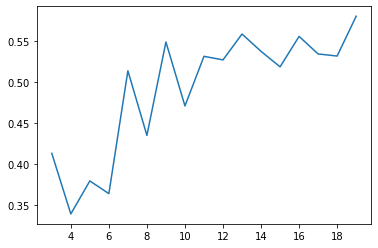

In [18]:
plt.plot(num_topics, coherence_scores)

##### Assign topic to documents

In [46]:
id_to_text = {
    0: 'vehicle',
    1: 'technology',
    2: 'ai',
    3: 'production',
    4: 'hyperloop',
    5: 'research',
    6: 'growth',
    7: 'analysis',
    8: 'expense',
    9: 'plan',
    10: 'finance',
    11: 'accident',
    12: 'projection',
    13: 'investment',
    14: 'environment',
    15: 'tax',
    16: 'trading',
    17: 'product',
    18: 'stock'
}

In [47]:
text_df

,id,title,content
7191,228706,"[expected, beat, earnings, estimate, buy]","[market, expects, nasdaq, deliver, year, year,..."
7192,228707,"[right, valuation, multiple]","[may, nasdaq, ceo, elon, musk, issued, warning..."
7193,228708,"[nio, electric, boogie]","[rough, couple, month, impeachment, market, st..."
7194,228709,"[toyota, tm, recall, vehicle, worldwide, airba...","[toyota, motor, corporation, nyse, tm, recall,..."
7199,228714,"[rally, still, leg]","[nasdaq, bull, field, day, past, month, equity..."
...,...,...,...
75524,297039,"[u, future, steady, ahead, data, dow, jones]","[investing, com, u, stock, future, pointed, st..."
75525,297040,"[u, stock, mixed, economic, report, dow, jones]","[investing, com, u, stock, opened, mixed, thur..."
75526,297041,"[cheaper, arrived, range]","[jerome, guillen, telsa, motor, inc, nasdaq, h..."
75527,297042,"[q, full, year, result, look]","[many, exciting, startup, market, watcher, inv..."


In [75]:
# Return document topics, list form 
def return_topics(lda_model, corpus, id_to_text):
    topic_ids = []
    topics = []
    for i in corpus:
        tmp = max(lda_model.get_document_topics(i), key=lambda x:x[1])[0]
        topic_ids.append(tmp)
        topics.append(id_to_text[tmp])
    return topic_ids, topics

In [76]:
topic_ids, topics = return_topics(content_model, corpus, id_to_text)

In [58]:
text_df.shape

(4283, 3)

In [77]:
text_df['topic_id'] = topic_ids
text_df['topic'] = topics

C:\Users\Yucheng\Anaconda3\envs\DSCI553\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Yucheng\Anaconda3\envs\DSCI553\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [78]:
text_df.head(5)

,id,title,content,topic_id,topic
7191,228706,"[expected, beat, earnings, estimate, buy]","[market, expects, nasdaq, deliver, year, year,...",13,investment
7192,228707,"[right, valuation, multiple]","[may, nasdaq, ceo, elon, musk, issued, warning...",9,plan
7193,228708,"[nio, electric, boogie]","[rough, couple, month, impeachment, market, st...",6,growth
7194,228709,"[toyota, tm, recall, vehicle, worldwide, airba...","[toyota, motor, corporation, nyse, tm, recall,...",9,plan
7199,228714,"[rally, still, leg]","[nasdaq, bull, field, day, past, month, equity...",18,stock


In [79]:
text_df.to_csv('news_topics.csv')